[Cell 1] 라이브러리 임포트 및 격자/해밀토니안 생성 함수

시스템: 4x4 (N=16), Hamiltonian 생성 중...
대각화 진행 중...

[Ground State Analysis]
Energy: -11.228483
Most probable configuration (Prob: 0.0826):
  ↑ ↓ ↑ ↓ 
  ↓ ↑ ↓ ↑ 
  ↑ ↓ ↑ ↓ 
  ↓ ↑ ↓ ↑ 
(Note: Quantum fluctuations mix this with other states)


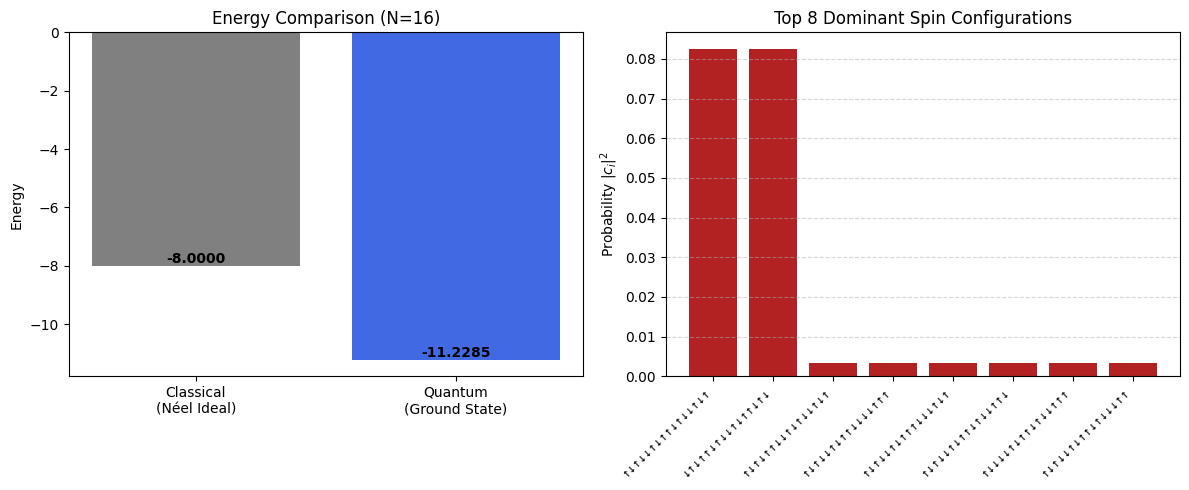

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# ==========================================
# 1. 시스템 설정
# ==========================================
Lx = 4
Ly = 4
N = Lx * Ly
J = 1.0  # AFM interaction

print(f"시스템: {Lx}x{Ly} (N={N}), Hamiltonian 생성 중...")

# ==========================================
# 2. 격자 및 해밀토니안 구성 (이전과 동일 로직)
# ==========================================
def get_neighbors_pbc(Lx, Ly):
    neighbors = set()
    for y in range(Ly):
        for x in range(Lx):
            i = y * Lx + x
            # Right neighbor
            j_r = y * Lx + (x + 1) % Lx
            neighbors.add(tuple(sorted((i, j_r))))
            # Up neighbor
            j_u = ((y + 1) % Ly) * Lx + x
            neighbors.add(tuple(sorted((i, j_u))))
    return sorted(list(neighbors))

def build_hamiltonian(N, bonds, J):
    dim = 2**N
    rows, cols, data = [], [], []
    
    for state in range(dim):
        for (i, j) in bonds:
            # i, j번째 비트 확인
            si = (state >> i) & 1
            sj = (state >> j) & 1
            
            # Diagonal (SzSz): 같은 방향 +0.25, 반대 -0.25
            if si == sj:
                rows.append(state); cols.append(state); data.append(0.25 * J)
            else:
                rows.append(state); cols.append(state); data.append(-0.25 * J)
                # Off-diagonal (Flip): 반대일 때만 flip 가능
                next_state = state ^ (1 << i) ^ (1 << j)
                rows.append(state); cols.append(next_state); data.append(0.5 * J)
                
    return coo_matrix((data, (rows, cols)), shape=(dim, dim)).tocsr()

bonds = get_neighbors_pbc(Lx, Ly)
H = build_hamiltonian(N, bonds, J)

# ==========================================
# 3. 대각화 (Ground State 계산)
# ==========================================
print("대각화 진행 중...")
evals, evecs = eigsh(H, k=1, which='SA')
E0 = evals[0].real
psi0 = evecs[:, 0] # 바닥상태 파동함수 벡터

# 고전적 Néel 에너지 (참조용)
E_cl = -0.25 * J * len(bonds)

# ==========================================
# 4. 바닥상태 분석 (가장 기여도가 높은 스핀 구성 찾기)
# ==========================================
probs = np.abs(psi0)**2  # 확률 밀도 |c_i|^2
top_k = 8  # 상위 k개 상태만 확인

# 확률 내림차순 정렬
top_indices = np.argsort(probs)[::-1][:top_k]
top_probs = probs[top_indices]

# 비트(정수)를 화살표 문자열로 변환하는 함수
def state_to_arrows(state_int, N, Lx):
    # 비트 문자열 변환 (ex: 0 -> ↓, 1 -> ↑)
    # LSB가 0번 사이트라고 가정
    chars = []
    for k in range(N):
        bit = (state_int >> k) & 1
        chars.append("↑" if bit == 1 else "↓")
    
    # 1D 배열을 시각적으로 끊어서 보여줄지 여부 (여기선 한줄로)
    full_str = "".join(chars)
    return full_str

top_labels = [state_to_arrows(idx, N, Lx) for idx in top_indices]

# 콘솔에 가장 확률 높은 상태 1개 2D 그리드로 출력
print(f"\n[Ground State Analysis]")
print(f"Energy: {E0:.6f}")
print(f"Most probable configuration (Prob: {top_probs[0]:.4f}):")
best_state = top_indices[0]
for y in range(Ly):
    row_str = ""
    for x in range(Lx):
        idx = y * Lx + x
        bit = (best_state >> idx) & 1
        row_str += "↑ " if bit else "↓ "
    print(f"  {row_str}")
print("(Note: Quantum fluctuations mix this with other states)")

# ==========================================
# 5. 시각화 (Energy + Wavefunction Components)
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# [왼쪽] 에너지 비교
ax[0].bar(['Classical\n(Néel Ideal)', 'Quantum\n(Ground State)'], [E_cl, E0], color=['gray', 'royalblue'])
ax[0].set_ylabel('Energy')
ax[0].set_title(f'Energy Comparison (N={N})')
# 값 표시
for i, v in enumerate([E_cl, E0]):
    ax[0].text(i, v, f"{v:.4f}", ha='center', va='bottom' if v<0 else 'top', fontweight='bold')

# [오른쪽] 바닥상태 구성 성분 (Top K Basis States)
ax[1].bar(range(top_k), top_probs, color='firebrick')
ax[1].set_xticks(range(top_k))
ax[1].set_xticklabels(top_labels, rotation=45, ha='right', fontsize=9, fontfamily='monospace')
ax[1].set_ylabel('Probability $|c_i|^2$')
ax[1].set_title(f'Top {top_k} Dominant Spin Configurations')
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

2. 코드: psi0로부터 상관함수 히트맵 그리기

<>:106: SyntaxWarning: invalid escape sequence '\p'
<>:106: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_4137094/360945865.py:106: SyntaxWarning: invalid escape sequence '\p'
  ax0.set_title('Classical Néel\n(Perfect Order: $\pm$0.25)', fontsize=14)



예시: 기준 사이트와 가장 가까운 이웃 상관함수들(양자):
[[ 0.0712551  -0.11696337  0.0712551  -0.06738806]
 [-0.11696337  0.25       -0.11696337  0.0712551 ]
 [ 0.0712551  -0.11696337  0.0712551  -0.06738806]
 [-0.06738806  0.0712551  -0.06738806  0.05987513]]


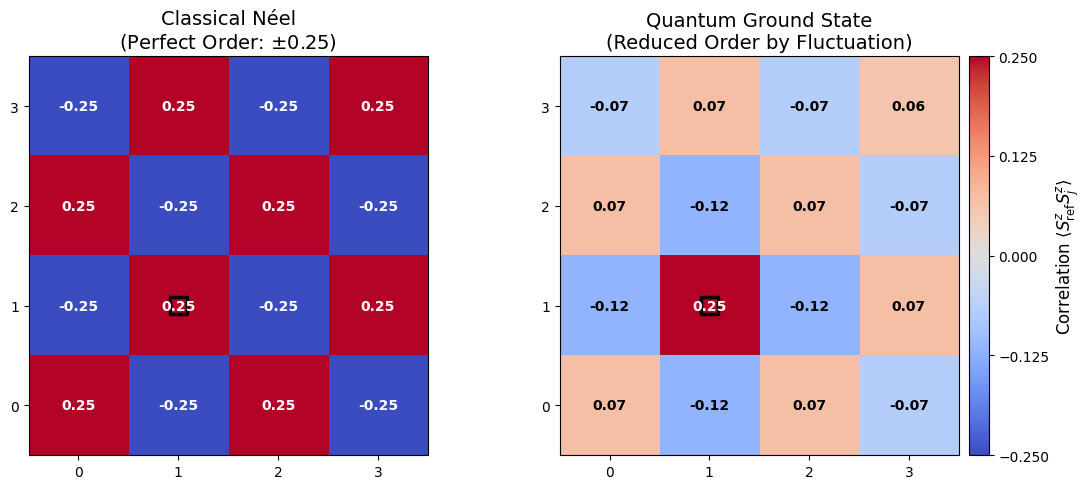

In [2]:
# ==========================================
# 7. 스핀-스핀 상관함수 C_ij^z = <S_i^z S_j^z> 계산
#    - 기준 사이트(ref_site)와의 상관함수를 2D 히트맵으로 표시
# ==========================================

def spin_corr_zz(psi, i, j, N):
    """
    <S_i^z S_j^z> 기대값을 직접 계산.
    - psi : 바닥상태 파동함수 (길이 2^N 벡터)
    - i, j: 사이트 인덱스 (0 ~ N-1)
    """
    dim = 2**N
    corr = 0.0

    for state in range(dim):
        amp = psi[state]
        if amp == 0:
            continue

        # i, j 사이트의 스핀 (0: ↓, 1: ↑)
        spin_i = (state >> i) & 1
        spin_j = (state >> j) & 1

        # S^z 고유값: ↑ -> +1/2, ↓ -> -1/2
        szi = 0.5 if spin_i == 1 else -0.5
        szj = 0.5 if spin_j == 1 else -0.5

        prob = (amp.conjugate() * amp).real
        corr += prob * szi * szj

    return corr

def quantum_corr_map_zz(psi, N, Lx, Ly, ref_x, ref_y):
    """
    기준 사이트 (ref_x, ref_y)와의 <S^z_i S^z_j> 상관함수 맵 (Ly x Lx) 생성
    """
    corr_map = np.zeros((Ly, Lx))
    ref_site = ref_y * Lx + ref_x

    for y in range(Ly):
        for x in range(Lx):
            j = y * Lx + x
            corr_map[y, x] = spin_corr_zz(psi, ref_site, j, N)

    return corr_map

def classical_neel_corr_map_zz(Lx, Ly, ref_x, ref_y, S=0.5):
    """
    이상적인 고전 Néel 상태(체스판 패턴, z-축 정렬)에서
    기준 사이트와의 <S^z_i S^z_j> 상관함수 맵 (Ly x Lx)
    
    - (x + y)가 짝수면 ↑, 홀수면 ↓ 라고 가정.
    """
    corr_map = np.zeros((Ly, Lx))
    parity_ref = (ref_x + ref_y) % 2

    for y in range(Ly):
        for x in range(Lx):
            parity = (x + y) % 2
            same_sub = (parity == parity_ref)
            # 같은 서브격자면 같은 방향 (↑↑ or ↓↓), 다르면 반대 방향 (↑↓ or ↓↑)
            sz_i = S  # 기준 사이트의 S^z = +S 또는 -S, 부호는 overall 상쇄되므로 S^2만 남음
            sz_j = S if same_sub else -S
            corr_map[y, x] = sz_i * sz_j  # = S^2 (same) 또는 -S^2 (diff)

    return corr_map

# 기준 사이트 선택 (중앙 근처 아무 데나, 여기선 (1,1) 선택)
ref_x, ref_y = 1, 1  # 0-based 인덱스: (x=1, y=1)

# 고전/양자 상관함수 맵 계산
C_classical = classical_neel_corr_map_zz(Lx, Ly, ref_x, ref_y, S=0.5)
C_quantum   = quantum_corr_map_zz(psi0, N, Lx, Ly, ref_x, ref_y)

print("\n예시: 기준 사이트와 가장 가까운 이웃 상관함수들(양자):")
print(C_quantum)


# ==========================================
# 8. 히트맵 시각화 (Classical vs Quantum) - 최종 수정
# ==========================================
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # 컬러바 전용 공간을 만들기 위한 도구

# 비교를 위해 최대/최소 범위를 이론값인 +/- 0.25로 고정합니다.
vmax = 0.25 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- 함수: 히트맵에 숫자 쓰기 ---
def add_value_labels(ax, data):
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            val = data[y, x]
            # 배경색에 따라 글자색 결정 (진하면 흰색, 연하면 검은색)
            text_color = 'white' if abs(val) > 0.15 else 'black'
            ax.text(x, y, f"{val:.2f}", ha='center', va='center', 
                    color=text_color, fontweight='bold')

# --------------------------
# 1) Classical Plot
# --------------------------
ax0 = axes[0]
im0 = ax0.imshow(C_classical, origin='lower', cmap='coolwarm',
                 vmin=-vmax, vmax=vmax)
ax0.set_title('Classical Néel\n(Perfect Order: $\pm$0.25)', fontsize=14)
ax0.set_xticks(range(Lx))
ax0.set_yticks(range(Ly))
# 기준 사이트 표시
ax0.scatter(ref_x, ref_y, marker='s', facecolors='none',
            edgecolors='k', s=150, linewidths=2.5)
# 숫자 추가
add_value_labels(ax0, C_classical)

# --------------------------
# 2) Quantum Plot
# --------------------------
ax1 = axes[1]
im1 = ax1.imshow(C_quantum, origin='lower', cmap='coolwarm',
                 vmin=-vmax, vmax=vmax)
ax1.set_title('Quantum Ground State\n(Reduced Order by Fluctuation)', fontsize=14)
ax1.set_xticks(range(Lx))
ax1.set_yticks(range(Ly))
ax1.scatter(ref_x, ref_y, marker='s', facecolors='none',
            edgecolors='k', s=150, linewidths=2.5)
# 숫자 추가
add_value_labels(ax1, C_quantum)

# --------------------------
# 3) Colorbar (오른쪽에 완벽하게 분리)
# --------------------------
# 오른쪽 그림(ax1)의 오른쪽에 공간을 만듭니다.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(im1, cax=cax)
cbar.set_label(r'Correlation $\langle S^z_{\mathrm{ref}} S^z_j \rangle$', fontsize=12)
# 컬러바에도 주요 눈금 표시
cbar.set_ticks([-0.25, -0.125, 0, 0.125, 0.25])

plt.tight_layout()
plt.show()